# Linear Models

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pymc3 as pm
import arviz as az

import warnings
warnings.filterwarnings("ignore")

### Why normal distributions are normal

#### Normal by addition

###### Figure 4.2

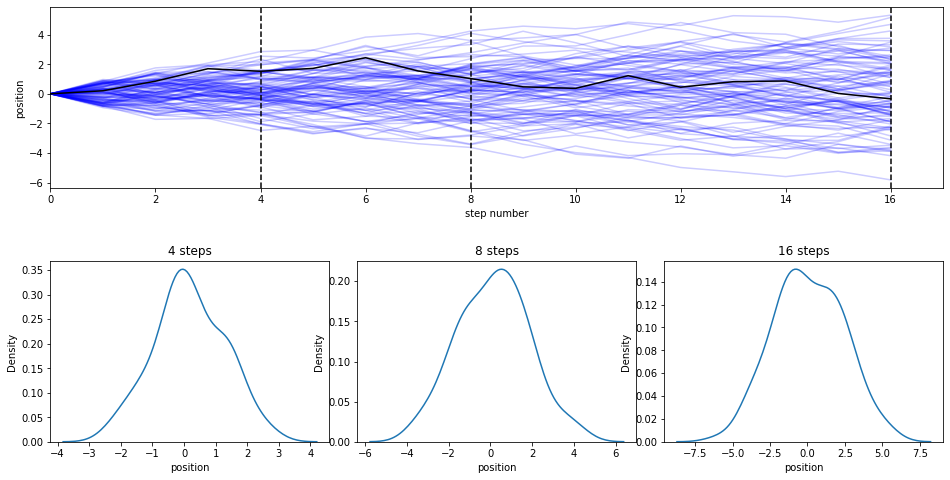

In [2]:
n_steps = 16
origin = 0
n_people = 100
coin_outcome = [-1,1]

# Simulate n_people's (each column is a person) n_steps (each row is a column) by random coin flip
# This makes a random flip of a coin and then picks a random step stize between 0 and 1 in the direction
start_points = np.zeros((1, n_people))
steps = np.random.choice(coin_outcome, size=(n_steps,n_people)) * np.random.rand(n_steps,n_people)

# Get final position after each coin flip
pos = np.append(start_points, steps, axis=0).cumsum(axis=0)

fig = plt.figure(figsize=(16, 8))
outer = gridspec.GridSpec(2, 1, wspace=0.2, hspace=0.4)

inner1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[0])
ax1 = plt.Subplot(fig, inner1[0])
ax1.plot(pos, color='b', alpha=0.2)
ax1.plot(pos[:,np.random.randint(0, n_people)], color='black')
ax1.set_xlabel('step number')
ax1.set_ylabel('position')
ax1.set_xlim([0,17])
ax1.axvline(4 , color='black', linestyle='--')
ax1.axvline(8 , color='black', linestyle='--')
ax1.axvline(16, color='black', linestyle='--')
fig.add_subplot(ax1)

inner2 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=outer[1], wspace=0.1)
for i, v in enumerate([4,8,16]):
    ax = plt.Subplot(fig, inner2[i])
    pos_at_step = pos[v,:]
    sns.kdeplot(pos_at_step, ax=ax)
    ax.set_title('{v} steps'.format(v=v))
    ax.set_xlabel('position')
    ax.set_ylabel('Density')
    fig.add_subplot(ax)

###### Code 4.1

In [3]:
pos = np.random.choice([-1,1], size=(1000, 16))
pos

array([[ 1, -1,  1, ..., -1,  1, -1],
       [-1,  1, -1, ...,  1,  1, -1],
       [-1,  1, -1, ..., -1,  1, -1],
       ...,
       [-1,  1, -1, ..., -1,  1, -1],
       [-1, -1,  1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]])

#### Normal by multiplication

###### Code 4.2

In [4]:
np.prod(1 + np.random.rand(12)*0.1)

1.6399275466723535

###### Code 4.3

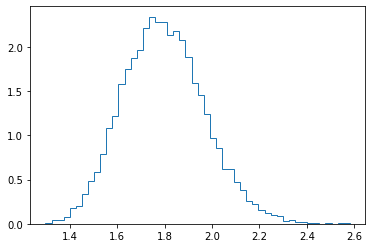

In [5]:
growth = np.prod(1 + 0.1*np.random.rand(12, 10000), axis=0)
plt.hist(growth, bins=50, density=True, histtype='step');

###### Code 4.4

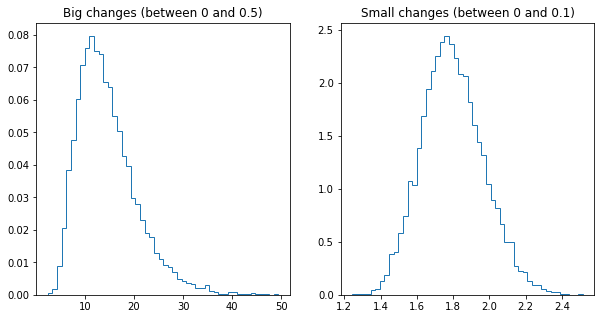

In [6]:
big = np.prod(1 + 0.5*np.random.rand(12, 10000), axis=0)
small = np.prod(1 + 0.1*np.random.rand(12, 10000), axis=0)


_, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))

ax1.hist(big, bins=50, density=True, histtype='step')
ax1.set_title('Big changes (between 0 and 0.5)')
ax2.hist(small, bins=50, density=True, histtype='step')
ax2.set_title('Small changes (between 0 and 0.1)');

#### Normal by log-multiplication

###### Code 4.5

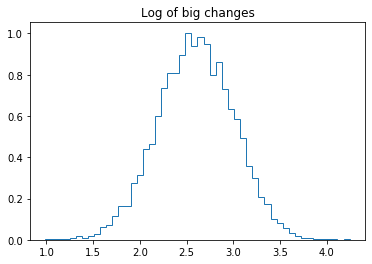

In [7]:
log_big = np.log(np.prod(1 + 0.5 * np.random.rand(12, 10000), axis=0))

plt.hist(log_big, bins=50, density=True, histtype='step')
plt.title('Log of big changes');

#### Using Gaussian distributions

### A language for describing models

#### Re-describing the globe tossing model

The number of ways, w, of landing on water and the fraction, p, of the world being water can be written as:

$$
\begin{align}
w &\sim Binomial(n, p) \\
p &\sim Uniform(0, 1)
\end{align}
$$

In Bayes theorem, the probability of the world being fraction p can be written as:

$$
\begin{align}
\text{Pr( p | w, n)} = \frac{\text{Binomial(w | n, p) Uniform(p | 0, 1)}}{\int\text{Binomial(w | n, p) Uniform(p | 0, 1)}dp}
\end{align}
$$

###### Code 4.6

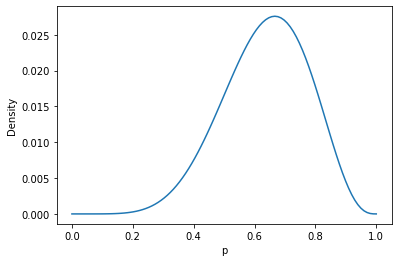

In [8]:
w = 6
n = 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / posterior.sum()

plt.plot(p_grid, posterior)
plt.xlabel('p')
plt.ylabel('Density');

### A Gaussian model of height

#### The data

###### Code 4.7

In [9]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')

###### Code 4.8

In [10]:
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


###### Code 4.9

In [11]:
d.height.head()

0    151.765
1    139.700
2    136.525
3    156.845
4    145.415
Name: height, dtype: float64

###### Code 4.10

In [12]:
d2 = d[d.age >= 18].reset_index(drop=True)

#### The model

The model for height, h, can be written as:

$$
\begin{align}
h_i &\sim \text{Normal( $\mu$, $\sigma$ )} \\
\mu &\sim \text{Normal( 178, 20 )} \\
\sigma &\sim \text{Uniform( 0, 50 )}
\end{align}
$$

###### Code 4.11

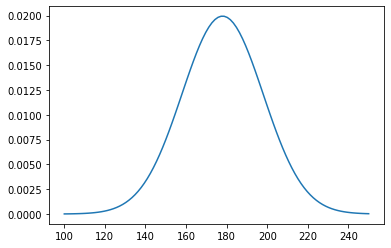

In [13]:
x = np.linspace(100, 250, 100)
plt.plot(x, stats.norm.pdf(x, 178, 20))

###### Code 4.12

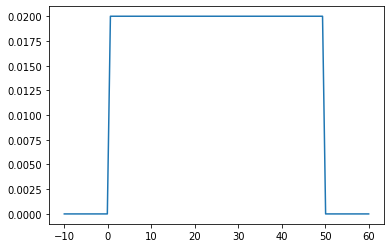

In [14]:
x = np.linspace(-10, 60, 100)
plt.plot(x, stats.uniform.pdf(x, 0, 50))

###### Code 4.13

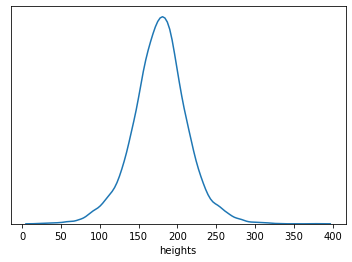

In [15]:
size=int(1e4)
sample_mu = stats.norm.rvs(size=size, loc=178, scale=20)
sample_sigma = stats.uniform.rvs(size=size, loc=0, scale=50)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)

sns.kdeplot(prior_h)
plt.xlabel('heights')
plt.yticks([]);

#### Grid approximation of the posterior distribution

###### Code 4.14

In [16]:
# Get all combinations of mu and sigma
post = np.mgrid[140:160:0.1, 4:9:0.1].reshape(2,-1).T

# calculate likelihoods at each combination of mu and sigma
likelihood = np.apply_along_axis(lambda x: np.sum(stats.norm.logpdf(d2.height, loc=x[0], scale=x[1])), axis=1, arr=post)

# calculate posterior unstandardized probability
post_prod = (
    likelihood +
    stats.norm.logpdf(post[:,0], loc=178, scale=20) +
    stats.uniform.logpdf(post[:,1], loc=0, scale=50)
)

# Calculate posterior standardized probability
# WHY SUBTRACT WITH MAX???????
post_prob = np.exp(post_prod - np.max(post_prod))

###### Code 4.15 and 4.16

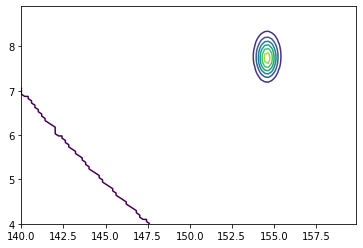

In [17]:
xi = np.linspace(post[:,0].min(), post[:,0].max(), 100)
yi = np.linspace(post[:,1].min(), post[:,1].max(), 100)
zi = griddata((post[:,0], post[:,1]), post_prob, (xi[None,:], yi[:,None]))

plt.contour(xi, yi, zi);

#### Sampling from the posterior

###### Code 4.17

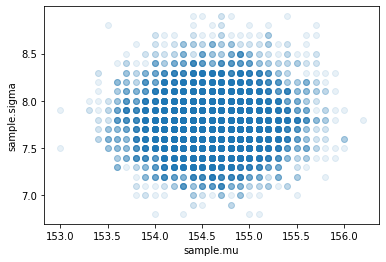

In [18]:
sample_rows = np.random.choice(range(len(post)), size=10000, replace=True, p=post_prob/post_prob.sum())
sample_mu = post[sample_rows, 0]
sample_sigma = post[sample_rows, 1]

plt.scatter(sample_mu, sample_sigma, alpha=0.1, marker='o')
plt.axis('equal')
plt.xlabel('sample.mu')
plt.ylabel('sample.sigma');

###### Code 4.19

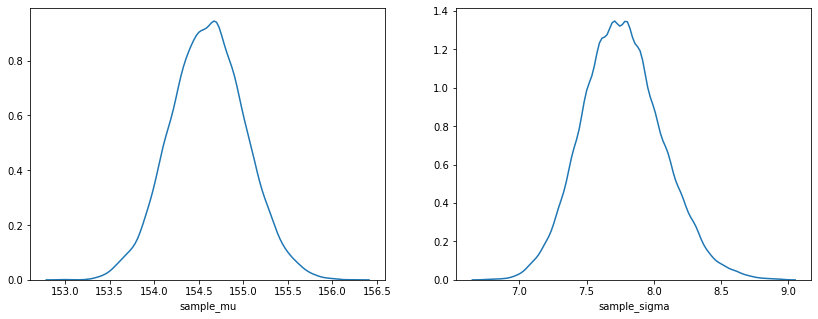

In [19]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(14,5))

sns.kdeplot(sample_mu, ax=ax1)
ax1.set_xlabel('sample_mu')
sns.kdeplot(sample_sigma, ax=ax2)
ax2.set_xlabel('sample_sigma');

###### Code 4.20

In [20]:
print('HPDI for mean:', pm.stats.hpd(sample_mu))
print('HPDI for sigma:', pm.stats.hpd(sample_sigma))

HPDI for mean: [153.8 155.3]
HPDI for sigma: [7.3 8.4]


###### Code 4.21

In [21]:
d3 = d2.height.sample(n=20)

###### Code 4.22

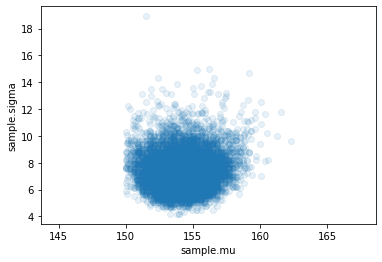

In [22]:
# Get all combinations of mu and sigma
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2,-1).T

# calculate likelihoods at each combination of mu and sigma
likelihood2 = np.apply_along_axis(lambda x: np.sum(stats.norm.logpdf(d3, loc=x[0], scale=x[1])), axis=1, arr=post2)

# calculate posterior unstandardized probability
post_prod2 = (
    likelihood2 +
    stats.norm.logpdf(post2[:,0], loc=178, scale=20) +
    stats.uniform.logpdf(post2[:,1], loc=0, scale=50)
)

# Calculate posterior standardized probability
# WHY SUBTRACT WITH MAX???????
post_prob2 = np.exp(post_prod2 - np.max(post_prod2))


sample_rows2 = np.random.choice(range(len(post2)), size=10000, replace=True, p=post_prob2/post_prob2.sum())
sample_mu2 = post2[sample_rows2, 0]
sample_sigma2 = post2[sample_rows2, 1]

plt.scatter(sample_mu2, sample_sigma2, alpha=0.1, marker='o')
plt.axis('equal')
plt.xlabel('sample.mu')
plt.ylabel('sample.sigma');

###### Code 4.23

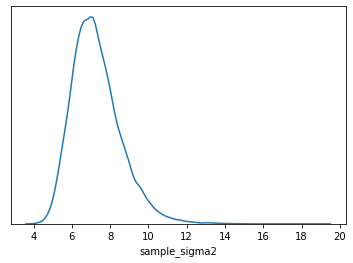

In [23]:
sns.kdeplot(sample_sigma2)
plt.xlabel('sample_sigma2')
plt.yticks([]);

#### Fitting the model with `map`

###### Code 4.24

In [24]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')
d2 = d[d.age >= 18]

###### Code 4.25

In [25]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2.height)

###### Code 4.26

In [26]:
trace_4_1 = pm.sample(1000, tune=1000, model=m4_1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1350.34draws/s]


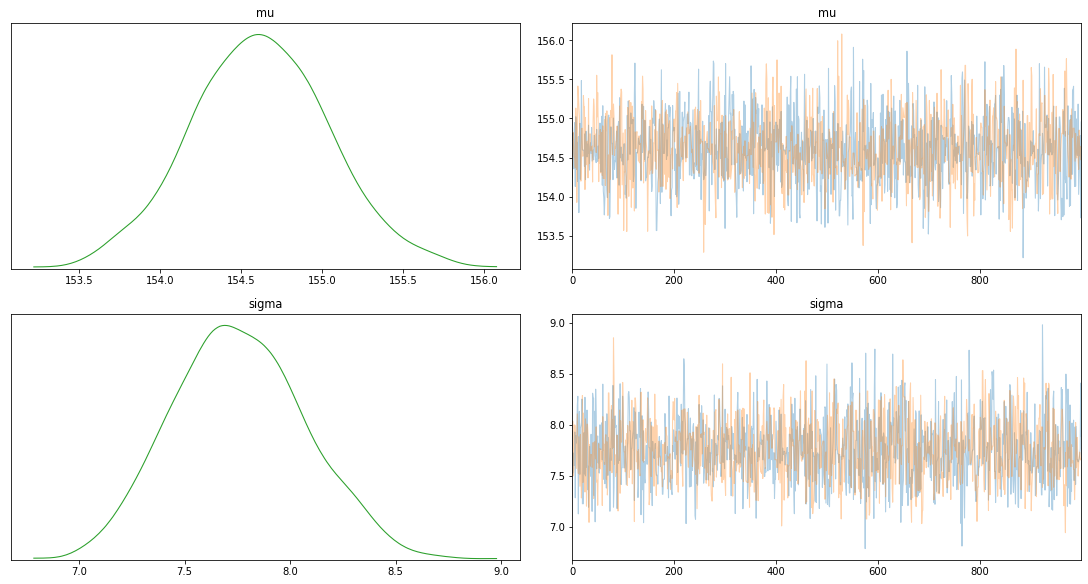

In [27]:
pm.plots.traceplot(trace_4_1, figsize=(15,8), combined=True);

###### Code 4.27

In [28]:
pm.stats.summary(trace_4_1, credible_interval=0.89, kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
mu,154.612,0.426,153.953,155.309
sigma,7.756,0.312,7.281,8.286


###### Code 4.28

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1766.41draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
mu,154.603,0.420,153.923,155.260
sigma,7.776,0.298,7.276,8.213


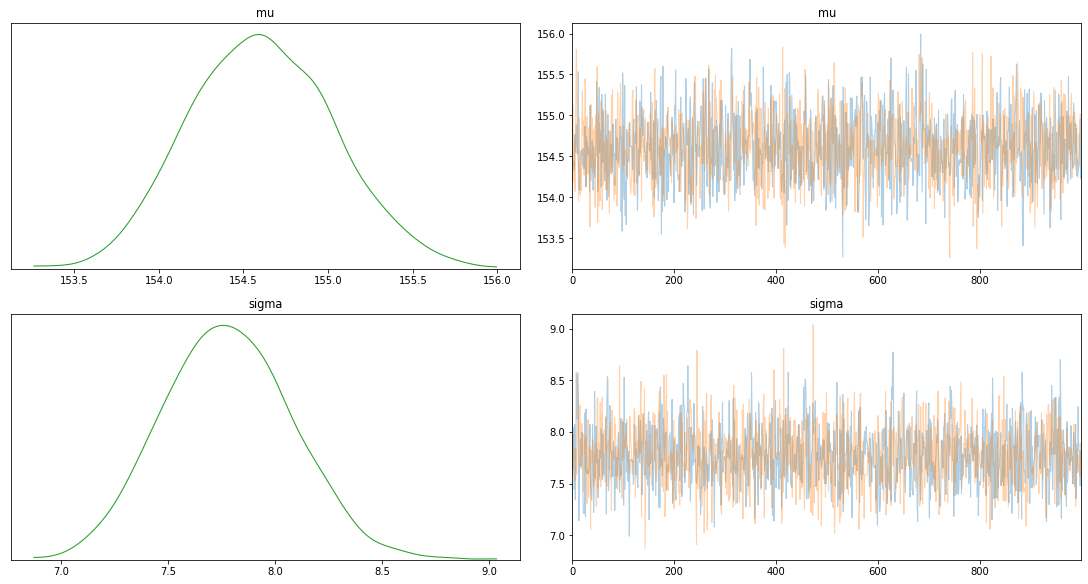

In [29]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20, testval=d2.height.mean())
    sigma = pm.Uniform('sigma', lower=0, upper=50, testval=d2.height.std())
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2.height)
    trace_4_1 = pm.sample(1000, tune=1000)
    
pm.plots.traceplot(trace_4_1, figsize=(15,8), combined=True);
pm.stats.summary(trace_4_1, credible_interval=0.89, kind='stats')

###### Code 4.29

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1831.95draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
mu,177.860,0.101,177.703,178.023
sigma,24.577,0.911,23.047,25.889


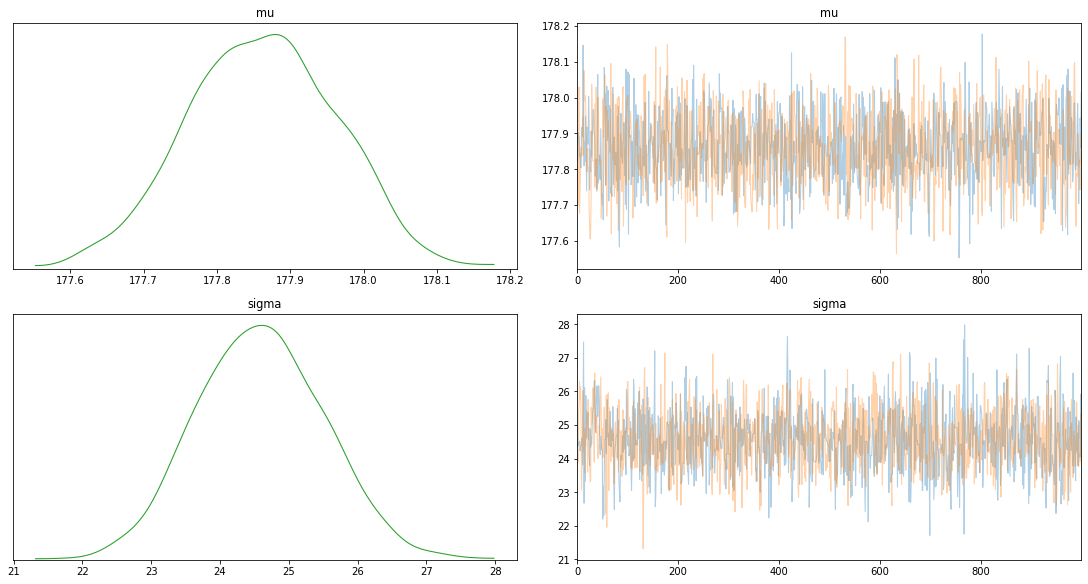

In [30]:
with pm.Model() as m4_2:
    mu = pm.Normal('mu', mu=178, sd=0.1)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2.height)
    trace_4_2 = pm.sample(1000, tune=1000)
    
pm.plots.traceplot(trace_4_2, figsize=(15,8), combined=True);
pm.stats.summary(trace_4_2, credible_interval=0.89, kind='stats')

#### Sampling from a `map` fit

###### Code 4.30

In [31]:
trace_df = pm.trace_to_dataframe(trace_4_1)
trace_df.cov()

,mu,sigma
mu,0.176136,-0.004936
sigma,-0.004936,0.088667


###### Code 4.31

In [32]:
np.diag(trace_df.cov())

array([0.17613601, 0.08866723])

In [33]:
trace_df.corr()

,mu,sigma
mu,1.000000,-0.039497
sigma,-0.039497,1.000000


###### Code 4.32

Since we used MCMC in our posterior approximation, trace_df already has sampled mu and sigma

In [34]:
trace_df.head(10)

,mu,sigma
0,154.478936,8.160673
1,154.428939,7.638979
2,154.428939,7.638979
3,154.409063,8.044465
4,154.333596,7.443965
5,154.768076,8.070222
6,154.555020,7.346938
7,154.683151,7.611830
8,154.884882,8.575216
9,154.635243,8.123893


In [35]:
# Option 2
trace_4_1['sigma'][:10]

array([8.16067339, 7.63897867, 7.63897867, 8.04446474, 7.44396455,
       8.07022152, 7.3469377 , 7.61182981, 8.57521563, 8.12389305])

###### Code 4.33

In [36]:
pm.stats.summary(trace_4_1, credible_interval=0.89, kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
mu,154.603,0.420,153.923,155.260
sigma,7.776,0.298,7.276,8.213


###### Code 4.34

In [37]:
stats.multivariate_normal.rvs(size=1000, mean=trace_df.mean(), cov=trace_df.cov())

array([[154.43004146,   7.93469518],
       [154.40382936,   8.06147475],
       [154.79173759,   7.29537481],
       ...,
       [154.59871816,   8.26713491],
       [154.31064841,   7.65927415],
       [154.78286869,   7.63900939]])

###### Code 4.35

In [38]:
with pm.Model() as m4_1_log_sigma:
    mu = pm.Normal('mu', mu=178, sd=20)
    log_sigma = pm.Lognormal('sigma', mu=2, sd=10)
    height = pm.Normal('height', mu=mu, sigma=log_sigma, observed=d2.height)

###### Code 4.36

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:01<00:00, 2158.80draws/s]


,mean,sd,hpd_5.5%,hpd_94.5%
mu,154.621,0.416,153.943,155.249
sigma,7.773,0.318,7.256,8.260


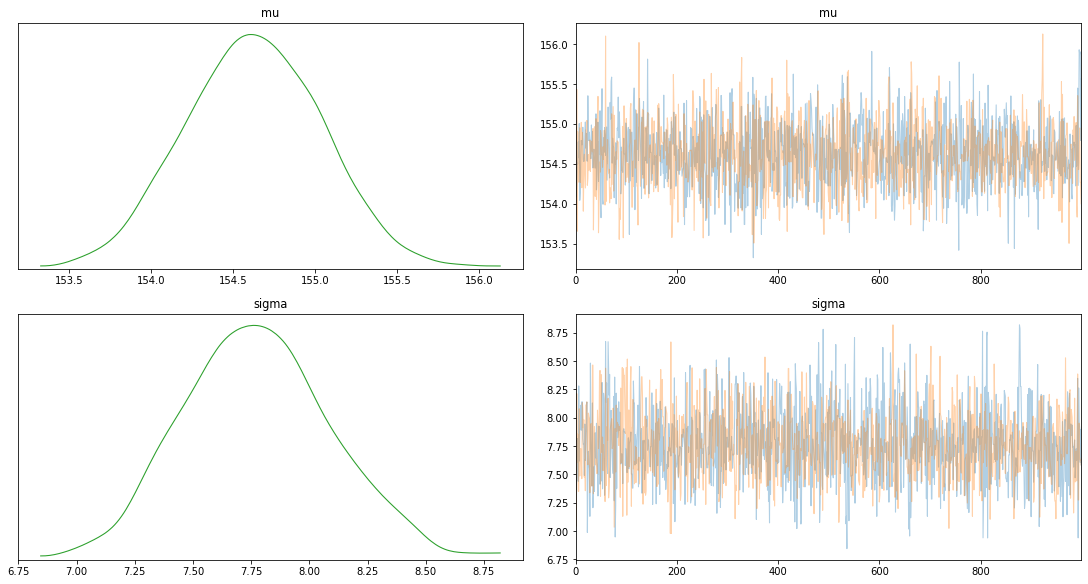

In [39]:
trace_4_1_logsigma = pm.sample(1000, tune=1000, model=m4_1_log_sigma)
pm.plots.traceplot(trace_4_1_logsigma, figsize=(15,8), combined=True);
pm.stats.summary(trace_4_1_logsigma, credible_interval=0.89, kind='stats')

### Adding a predictor

###### Code 4.37

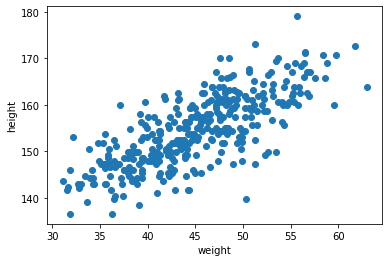

In [40]:
plt.scatter(d2.weight, d2.height)
plt.xlabel('weight')
plt.ylabel('height');

#### The linear model strategy

#### Fitting the model

###### Code 4.38

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:07<00:00, 503.47draws/s]


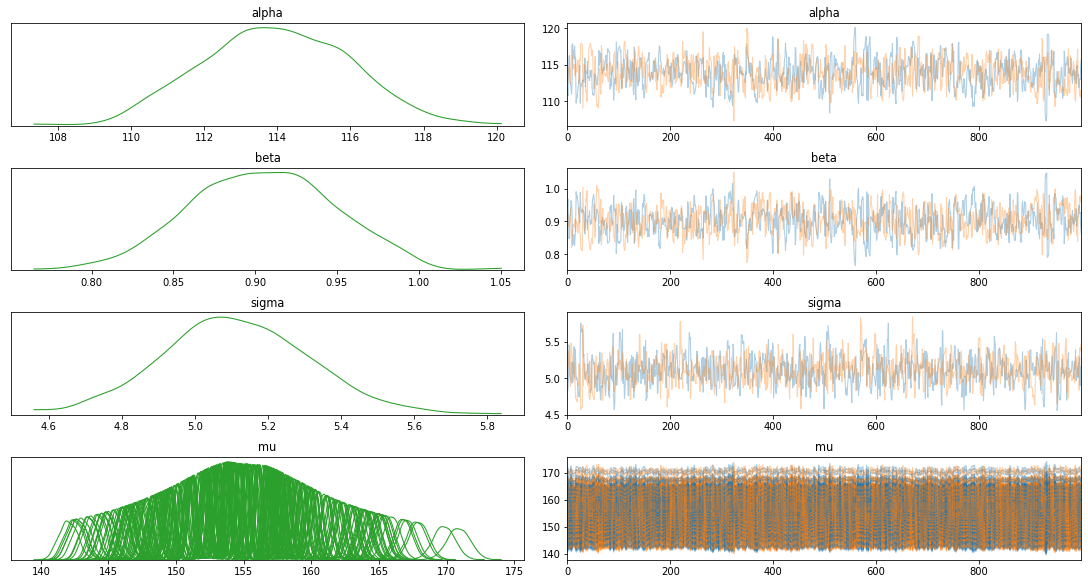

In [41]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')
d2 = d[d.age >= 18]

with pm.Model() as m4_3:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    alpha = pm.Normal('alpha', mu=156, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
#     mu = alpha + beta * d2.weight
    mu = pm.Deterministic('mu', alpha + beta * d2.weight)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)
    
pm.plots.traceplot(trace_4_3, figsize=(15,8), combined=True, compact=True);

###### Code 4.39

In [42]:
with pm.Model() as m4_3:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    alpha = pm.Normal('alpha', mu=156, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    height = pm.Normal('height', mu=alpha + beta * d2.weight, sigma=sigma, observed=d2.height)
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:07<00:00, 553.11draws/s]
The acceptance probability does not match the target. It is 0.8863179758500228, but should be close to 0.8. Try to increase the number of tuning steps.


#### Interpreting the model fit

##### Table of estimates

###### Code 4.40

In [43]:
pm.stats.summary(trace_4_3, credible_interval=0.89, kind='stats')

,mean,sd,hpd_5.5%,hpd_94.5%
alpha,113.878,1.962,110.835,116.977
beta,0.905,0.043,0.838,0.975
sigma,5.109,0.190,4.813,5.410


###### Code 4.41

In [44]:
trace_df = pm.trace_to_dataframe(trace_4_3)
trace_df.corr().round(2)

,alpha,beta,sigma
alpha,1.00,-0.99,0.03
beta,-0.99,1.00,-0.03
sigma,0.03,-0.03,1.00


###### Code 4.42

In [45]:
d2['weight_c'] = d2.weight - d2.weight.mean()

###### Code 4.43

In [46]:
with pm.Model() as m4_4:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    height = pm.Normal('height', mu=alpha + beta * d2.weight_c, sigma=sigma, observed=d2.height)
    trace_4_4 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1905.48draws/s]


###### Code 4.44

In [47]:
stats = pm.stats.summary(trace_4_4, credible_interval=0.89, kind='stats')
trace_df = pm.trace_to_dataframe(trace_4_4)
stats.join(trace_df.corr().round(3))

,mean,sd,hpd_5.5%,hpd_94.5%,alpha,beta,sigma
alpha,154.590,0.278,154.148,155.028,1.00,0.010,-0.040
beta,0.905,0.045,0.837,0.980,0.01,1.000,-0.026
sigma,5.105,0.193,4.783,5.402,-0.04,-0.026,1.000


###### Code 4.45

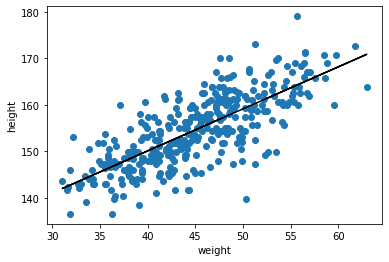

In [48]:
plt.plot(d2.weight, d2.height, 'o')
plt.plot(d2.weight, trace_4_3['alpha'].mean() + trace_4_3['beta'].mean() * d2.weight, color='black')
plt.xlabel('weight')
plt.ylabel('height');

###### Code 4.46

In [49]:
post = pm.trace_to_dataframe(trace_4_4)

###### Code 4.47

In [50]:
post.head()

,alpha,beta,sigma
0,154.713728,0.912531,4.937076
1,154.468181,0.894560,5.215558
2,154.422709,0.949142,5.044131
3,154.422709,0.949142,5.044131
4,154.777541,0.837079,5.271532


###### Code 4.48

In [51]:
N = 10
dN = d2[:N]

with pm.Model() as mN:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    mu = alpha + beta * dN.weight
    height = pm.Normal('height', mu=mu, sd=sigma, observed=dN.height)

###### Code 4.49

Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 1040/1040 [00:01<00:00, 762.69draws/s]


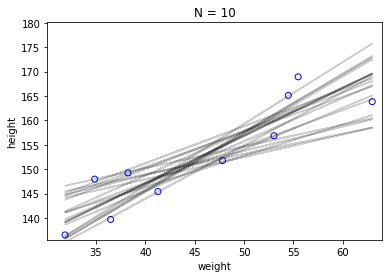

In [52]:
n_samples = 20
trace_N = pm.sample(n_samples, model=mN)
plt.scatter(dN.weight, dN.height, facecolors='none', edgecolors='b')
plt.title('N = {}'.format(N))
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim([d2.weight.min() - 1, d2.weight.max() + 1])
plt.ylim([d2.height.min() - 1, d2.height.max() + 1])
for x in range(n_samples):
    plt.plot(dN.weight, trace_N['alpha'][x] + trace_N['beta'][x] * dN.weight, color='black', alpha=0.2)
plt.show();

###### Figure 4.5

Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 1 divergences: 100%|██████████| 2040/2040 [00:02<00:00, 744.72draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2040/2040 [00:03<00:00, 596.56draws/s]
Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 2040/2040 [00:03<00:00, 538.26draws/s]
Only 20 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains

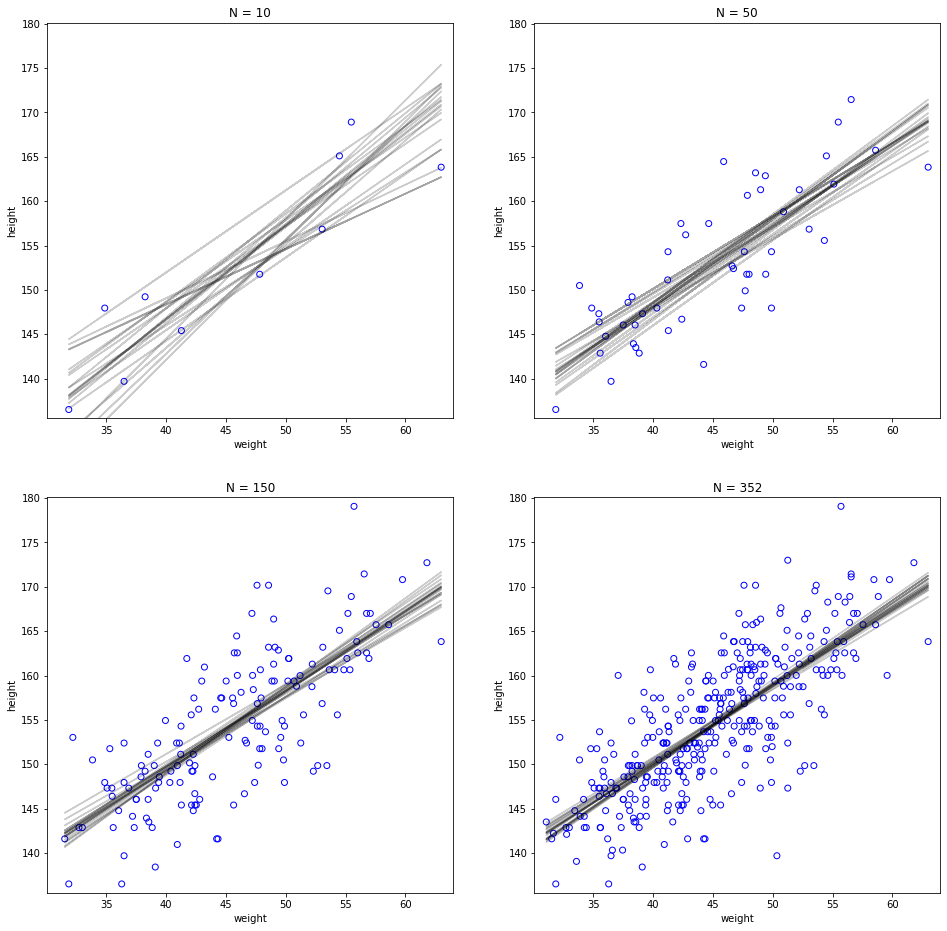

In [53]:
n_samples = 20
plt.figure(figsize=(16,16))

for idx, N in enumerate([10, 50, 150, 352]):
    dN = d2[:N]
    with pm.Model() as mn:
        sigma = pm.Uniform('sigma', lower=0, upper=50)
        alpha = pm.Normal('alpha', mu=178, sd=100)
        beta = pm.Normal('beta', mu=0, sd=10)
        mu = pm.Deterministic('mu', alpha + beta * dN.weight)
        height = pm.Normal('height', mu=mu, sd=sigma, observed=dN.height)
        chain_N = pm.sample(n_samples, tune=1000)

    plt.subplot(2, 2, idx+1)
    plt.scatter(dN.weight, dN.height, facecolors='none', edgecolors='b')
    plt.title('N = {}'.format(N))
    plt.xlabel('weight')
    plt.ylabel('height')
    plt.xlim([d2.weight.min() - 1, d2.weight.max() + 1])
    plt.ylim([d2.height.min() - 1, d2.height.max() + 1])
    for x in range(n_samples):
        plt.plot(dN.weight, chain_N['alpha'][x] + chain_N['beta'][x] * dN.weight, color='black', alpha=0.2)
        
plt.show()

###### Code 4.50

In [54]:
chain_N = pm.sample(5000, tune=1000, model=mn)
mu_at_50 = chain_N['alpha'] + chain_N['beta'] * 50

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 12000/12000 [00:21<00:00, 560.02draws/s]


###### Code 4.51

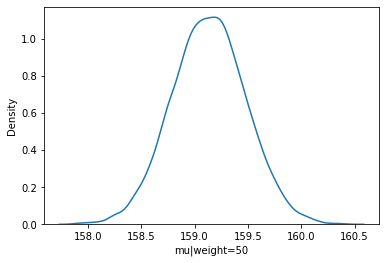

In [55]:
sns.kdeplot(mu_at_50)
plt.xlabel('mu|weight=50')
plt.ylabel('Density');

###### Code 4.52

In [56]:
pm.stats.hpd(mu_at_50, credible_interval=0.89)

array([158.55297887, 159.65660136])

###### Code 4.53

In [57]:
df_trace_N = pm.trace_to_dataframe(chain_N).filter(regex=('mu.*'))
df_trace_N.head()

,mu__0,mu__1,mu__2,mu__3,mu__4,mu__5,mu__6,mu__7,mu__8,mu__9,...,mu__342,mu__343,mu__344,mu__345,mu__346,mu__347,mu__348,mu__349,mu__350,mu__351
0,156.897948,147.230289,143.290718,161.345072,151.314875,169.828443,148.728776,163.423618,145.852648,162.577698,...,153.659282,156.946287,149.719711,151.121522,150.928169,156.221212,145.320926,160.595828,162.215161,160.910027
1,157.354409,146.416083,141.958715,162.386038,151.037525,171.984419,148.111523,164.737778,144.857371,163.780675,...,153.690069,157.409100,149.232702,150.818759,150.599992,156.588726,144.255763,161.538318,163.370488,161.893814
2,157.354409,146.416083,141.958715,162.386038,151.037525,171.984419,148.111523,164.737778,144.857371,163.780675,...,153.690069,157.409100,149.232702,150.818759,150.599992,156.588726,144.255763,161.538318,163.370488,161.893814
3,157.338102,147.943092,144.114625,161.659806,151.912484,169.903928,149.399318,163.679734,146.604303,162.857670,...,154.190773,157.385077,150.362307,151.724583,151.536683,156.680451,146.087577,160.931693,162.505357,161.237031
4,156.860779,147.293766,143.395208,161.261604,151.335829,169.656658,148.776653,163.318512,145.930467,162.481398,...,153.655829,156.908614,149.757272,151.144489,150.953148,156.191088,145.404281,160.520161,162.122636,160.831089


###### Code 4.54

In [58]:
weight_seq = np.arange(25, 70, 1)
mu_pred = np.zeros((len(weight_seq), len(chain_N)*chain_N.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = chain_N['alpha'] + chain_N['beta'] * w

mu_pred[:5,]

array([[137.4381529 , 135.33691969, 135.33691969, ..., 136.84825025,
        137.61446472, 138.18068147],
       [138.29069522, 136.3015157 , 136.3015157 , ..., 137.71471414,
        138.48721644, 139.01418218],
       [139.14323753, 137.2661117 , 137.2661117 , ..., 138.58117804,
        139.35996817, 139.8476829 ],
       [139.99577985, 138.23070771, 138.23070771, ..., 139.44764193,
        140.23271989, 140.68118361],
       [140.84832217, 139.19530372, 139.19530372, ..., 140.31410582,
        141.10547161, 141.51468433]])

###### Code 4.55

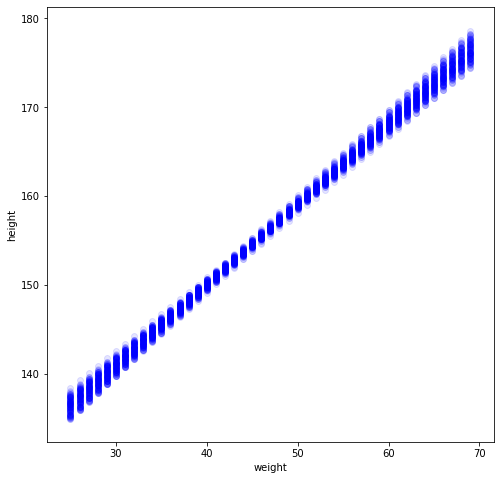

In [59]:
plt.figure(figsize=(8,8))
plt.xlabel('weight')
plt.ylabel('height')
plt.scatter(d2.weight, d2.height, facecolors='none')
for i in range(100):
    plt.scatter(weight_seq, mu_pred[:,i], alpha=0.1, color='b')

###### Code 4.56

In [60]:
mu_mean = mu_pred.mean(axis=1)
mu_hpdi = np.apply_along_axis(lambda x: pm.stats.hpd(x, credible_interval=0.89), axis=1, arr=mu_pred)

###### Code 4.57

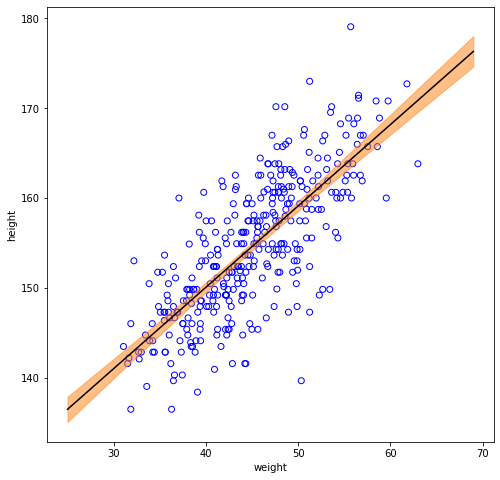

In [61]:
plt.figure(figsize=(8,8))
plt.xlabel('weight')
plt.ylabel('height')
plt.scatter(d2.weight, d2.height, facecolors='none', edgecolors='b')
plt.plot(weight_seq, mu_mean, 'k')
pm.plot_hpd(weight_seq, mu_pred.T, credible_interval=0.89)

###### Code 4.58

In [62]:
weight_seq = np.arange(25, 70, 1)
mu_pred = np.zeros((len(weight_seq), len(chain_N)*chain_N.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = chain_N['alpha'] + chain_N['beta'] * w

mu_mean = mu_pred.mean(axis=1)
mu_hpdi = np.apply_along_axis(lambda x: pm.stats.hpd(x, credible_interval=0.89), axis=1, arr=mu_pred)

###### Code 4.59

In [63]:
sim_height = pm.sample_posterior_predictive(chain_N, 200, m4_3)
sim_height['height']

100%|██████████| 200/200 [00:00<00:00, 735.32it/s]


array([[153.12261672, 142.96296916, 150.52563804, ..., 151.59776149,
        171.97458255, 156.38934158],
       [154.36032579, 143.68571805, 132.39459463, ..., 163.73662085,
        159.29750551, 159.58320214],
       [153.82826901, 146.8345814 , 139.43619016, ..., 163.30240979,
        170.3050674 , 167.19098863],
       ...,
       [166.62236056, 151.50088917, 135.65681701, ..., 162.20325824,
        158.96433857, 153.97315713],
       [159.02655388, 150.90286919, 139.75679033, ..., 164.1274514 ,
        168.73590889, 165.4487561 ],
       [155.60456244, 141.58749919, 134.45731631, ..., 161.3561548 ,
        163.45394585, 151.51652788]])

###### Code 4.60

In [64]:
height_pi = np.percentile(sim_height['height'], [0.05, 0.95], axis=0).T

###### Code 4.61

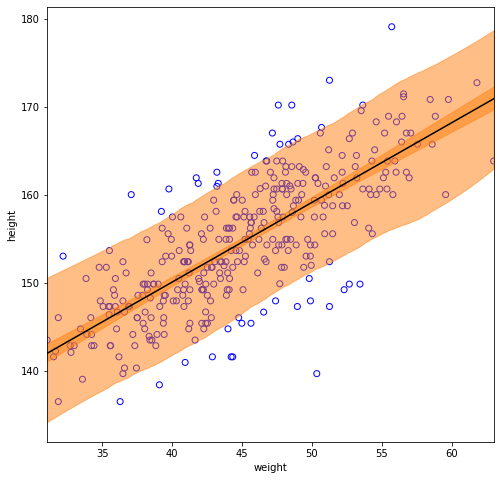

In [65]:
plt.figure(figsize=(8,8))
plt.xlabel('weight')
plt.ylabel('height')
plt.scatter(d2.weight, d2.height, facecolors='none', edgecolors='b')
plt.plot(weight_seq, mu_mean, 'k')
pm.plot_hpd(weight_seq, mu_pred.T, credible_interval=0.89)
pm.plot_hpd(d2.weight, sim_height['height'], credible_interval=0.89)
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

###### Code 4.62

100%|██████████| 10000/10000 [00:10<00:00, 962.02it/s]


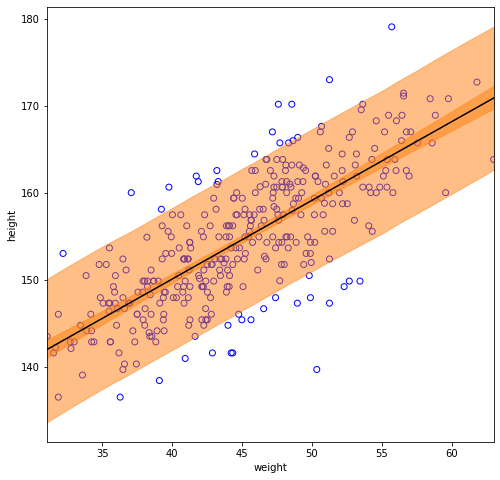

In [66]:
sim_height = pm.sample_posterior_predictive(chain_N, 10000, m4_3)
plt.figure(figsize=(8,8))
plt.xlabel('weight')
plt.ylabel('height')
plt.scatter(d2.weight, d2.height, facecolors='none', edgecolors='b')
plt.plot(weight_seq, mu_mean, 'k')
pm.plot_hpd(weight_seq, mu_pred.T, credible_interval=0.89)
pm.plot_hpd(d2.weight, sim_height['height'], credible_interval=0.89)
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

###### Code 4.63

In [67]:
weight_seq = np.arange(25, 70)
post_samples = []
for _ in range(1000): # number of samples from the posterior
    i = np.random.randint(len(chain_N))
    mu_pr = chain_N['alpha'][i] + chain_N['beta'][i] * weight_seq
    sigma_pred = chain_N['sigma'][i]
    post_samples.append(np.random.normal(mu_pr, sigma_pred))

In [68]:
np.shape(mu_pr)

(45,)

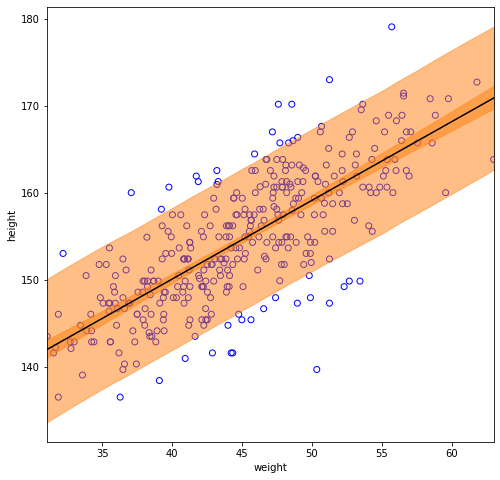

In [69]:
plt.figure(figsize=(8,8))
plt.xlabel('weight')
plt.ylabel('height')
plt.scatter(d2.weight, d2.height, facecolors='none', edgecolors='b')
plt.plot(weight_seq, mu_mean, 'k')
pm.plot_hpd(weight_seq, mu_pred.T, credible_interval=0.89)
pm.plot_hpd(d2.weight, sim_height['height'], credible_interval=0.89)
plt.xlim(d2.weight[:N].min(), d2.weight[:N].max());

#### Polynomial Regression

###### Code 4.64

In [70]:
d = pd.read_csv('../../data/Howell1.csv', sep=';')
d.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


###### Code 4.65

In [71]:
d['weight_s'] = (d.weight - d.weight.mean()) / d.weight.std()

###### Code 4.66

In [72]:
d['weight_s2'] = np.power(d.weight_s, 2)
with pm.Model() as m4_5:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    mu = pm.Deterministic('mu', alpha + beta[0] * d.weight_s + beta[1] * d.weight_s2)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
Sampling 2 chains, 0 divergences: 100%|██████████| 4000/4000 [00:02<00:00, 1416.72draws/s]


###### Code 4.67

In [73]:
pm.stats.summary(trace_4_5, credible_interval=0.89, kind='stats', var_names=['~mu'])

,mean,sd,hpd_5.5%,hpd_94.5%
alpha,146.642,0.378,146.016,147.205
beta[0],21.407,0.284,20.998,21.881
beta[1],-8.407,0.284,-8.841,-7.952
sigma,5.785,0.181,5.497,6.061


###### Code 4.68

In [74]:
n_obs = 30
chain_N = trace_4_5[:n_obs // 2]
weight_seq = np.linspace(-2.2, 2, n_obs)
n_samples = 1000
mu_pred = np.empty(shape=(n_samples, n_obs))
sim_height = np.empty(shape=(n_samples, n_obs))
for n in range(n_samples):
    i = np.random.randint(len(chain_N))
    mu = chain_N['alpha'][i] + chain_N['beta'][:,0] * weight_seq + chain_N['beta'][:,1] * np.power(weight_seq, 2)
    mu_pred[n,] = mu
    sigma = chain_N['sigma'][i]
    sim_height[n,] = np.random.normal(mu, sigma)
    
mu_mean = mu_pred.mean(axis=0)

###### Code 4.69

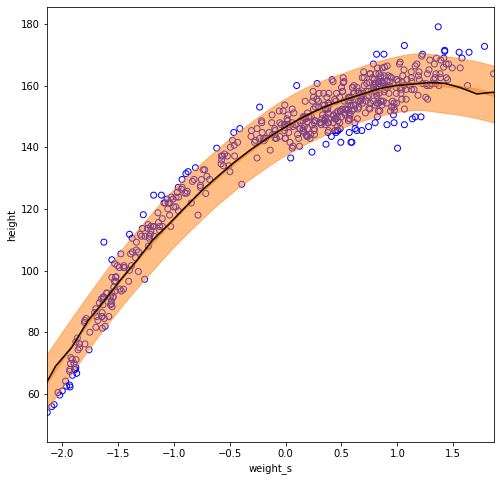

In [75]:
plt.figure(figsize=(8,8))
plt.xlabel('weight_s')
plt.ylabel('height')
plt.scatter(d.weight_s, d.height, facecolors='none', edgecolors='b')
plt.plot(weight_seq, mu_mean, 'k')
pm.plot_hpd(weight_seq, mu_pred, credible_interval=0.89)
pm.plot_hpd(weight_seq, sim_height, credible_interval=0.89)
plt.xlim(d.weight_s.min(), d.weight_s.max());

###### Figure 4.9

In [76]:
np.shape(mu_mean)

(30,)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
100%|██████████| 1000/1000 [00:00<00:00, 1000.97it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
100%|██████████| 1000/1000 [00:01<00:00, 915.60it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
100%|██████████| 1000/1000 [00:01<00:00, 963.80it/s]


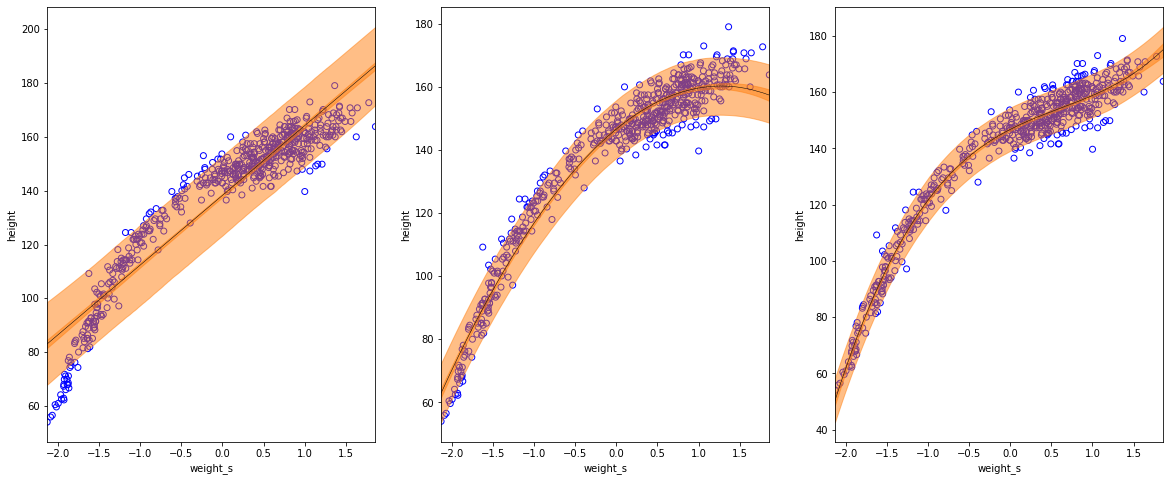

In [77]:
plt.figure(figsize=(20,8))

# Linear fit
with pm.Model() as m4_5:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    mu = pm.Deterministic('mu', alpha + beta * d.weight_s)
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)
    sim_height = pm.sample_posterior_predictive(trace_4_5, 1000)['height']

mu_pred = trace_4_5['mu']
mu_mean = mu_pred.mean(axis=0)
plt.subplot(1,3,1)
plt.xlabel('weight_s')
plt.ylabel('height')
plt.scatter(d.weight_s, d.height, facecolors='none', edgecolors='b')
sns.lineplot(d.weight_s, mu_mean, ci=None, color='black', linewidth=0.5)
pm.plot_hpd(d.weight_s, mu_pred, credible_interval=0.89)
pm.plot_hpd(d.weight_s, sim_height, credible_interval=0.89)
plt.xlim(d.weight_s.min(), d.weight_s.max());

# Quadratic fit
with pm.Model() as m4_5:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)
    mu = pm.Deterministic('mu', alpha + beta[0] * d.weight_s + beta[1] * np.power(d.weight_s, 2))
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)
    sim_height = pm.sample_posterior_predictive(trace_4_5, 1000)['height']

mu_pred = trace_4_5['mu']
mu_mean = mu_pred.mean(axis=0)
plt.subplot(1,3,2)
plt.xlabel('weight_s')
plt.ylabel('height')
plt.scatter(d.weight_s, d.height, facecolors='none', edgecolors='b')
sns.lineplot(d.weight_s, mu_mean, ci=None, color='black', linewidth=0.5)
pm.plot_hpd(d.weight_s, mu_pred, credible_interval=0.89)
pm.plot_hpd(d.weight_s, sim_height, credible_interval=0.89)
plt.xlim(d.weight_s.min(), d.weight_s.max())


# Quadratic fit
with pm.Model() as m4_5:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    mu = pm.Deterministic('mu', alpha + beta[0] * d.weight_s + beta[1] * np.power(d.weight_s, 2)  + beta[2] * np.power(d.weight_s, 3))
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d.height)
    trace_4_5 = pm.sample(1000, tune=1000)
    sim_height = pm.sample_posterior_predictive(trace_4_5, 1000)['height']

mu_pred = trace_4_5['mu']
mu_mean = mu_pred.mean(axis=0)
plt.subplot(1,3,3)
plt.xlabel('weight_s')
plt.ylabel('height')
plt.scatter(d.weight_s, d.height, facecolors='none', edgecolors='b')
sns.lineplot(d.weight_s, mu_mean, ci=None, color='black', linewidth=0.5)
pm.plot_hpd(d.weight_s, mu_pred, credible_interval=0.89)
pm.plot_hpd(d.weight_s, sim_height, credible_interval=0.89)
plt.xlim(d.weight_s.min(), d.weight_s.max());

###### Code 4.70

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, alpha, sigma]
100%|██████████| 1000/1000 [00:01<00:00, 944.83it/s]


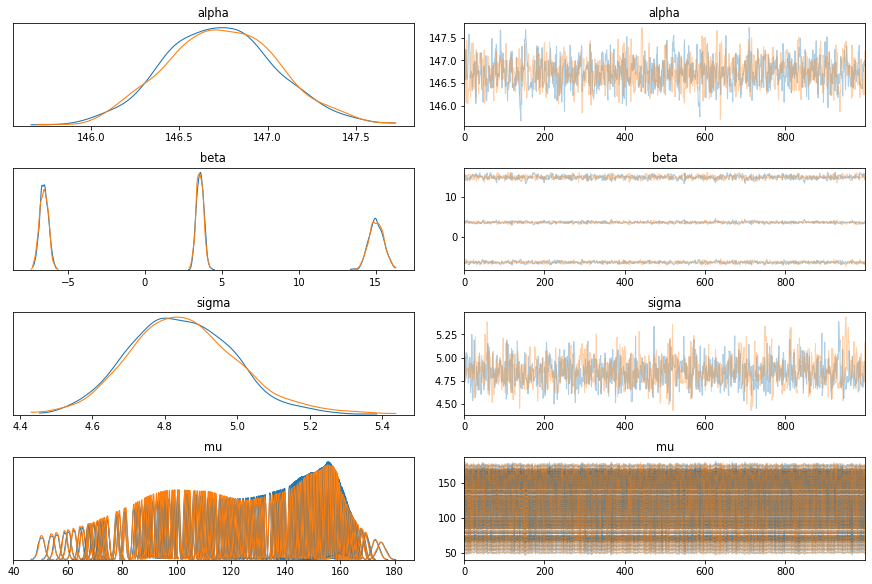

In [78]:
weight_m = np.vstack((d.weight_s, d.weight_s**2, d.weight_s**3))
with pm.Model() as m4_6:
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10, shape=3)
    mu = pm.Deterministic('mu', alpha + pm.math.dot(beta, weight_m))
    height = pm.Normal('height', mu=mu, sigma=sigma, observed=d.height)
    trace_4_6 = pm.sample(1000, tune=1000)
    sim_height = pm.sample_posterior_predictive(trace_4_6, 1000)['height']

pm.traceplot(trace_4_6);

###### Code 4.71

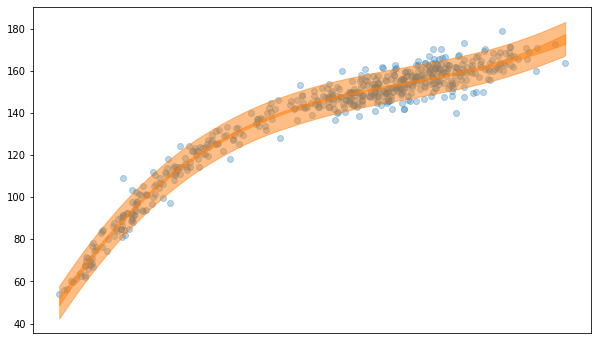

In [79]:
plt.figure(figsize=(10,6))
plt.scatter(d.weight_s, d.height, c='C0', alpha=0.3)
az.plot_hpd(d.weight_s, mu_pred, credible_interval=.89)
az.plot_hpd(d.weight_s, sim_height, credible_interval=.89)
plt.xticks([]);

###### Code 4.72

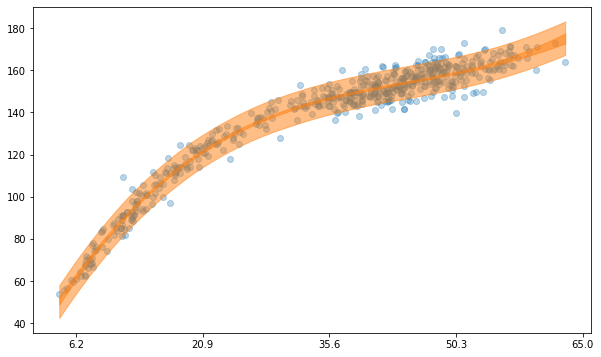

In [80]:
plt.figure(figsize=(10,6))
plt.scatter(d.weight_s, d.height, c='C0', alpha=0.3)
az.plot_hpd(d.weight_s, mu_pred, credible_interval=.89)
az.plot_hpd(d.weight_s, sim_height, credible_interval=.89)

at = np.arange(-2, 3)
plt.xticks(at, np.round(at * d.weight.std() + d.weight.mean(), 1));

In [81]:
import sys, IPython, scipy, matplotlib, platform, statsmodels, arviz
print("""
This notebook was created using:\nPython {}\nIPython {}\nPyMC3 {}\nSeaborn {}\nNumPy {}\nPandas {}\nStatsmodels {}\nMatplotlib {}\nScipy {}\nArviz {}\n
""".format(sys.version[:5], IPython.__version__, pm.__version__, sns.__version__, np.__version__, pd.__version__, statsmodels.__version__, matplotlib.__version__, scipy.__version__, arviz.__version__))



This notebook was created using:
Python 3.7.6
IPython 7.12.0
PyMC3 3.8
Seaborn 0.10.0
NumPy 1.18.1
Pandas 1.0.1
Statsmodels 0.11.0
Matplotlib 3.1.3
Scipy 1.4.1
Arviz 0.6.1


